## Searching best candidate in quarternary alloy compositions for optimal value of 

$y = y_{uts}+y_{ys}$

where $y_{uts}$ represents the ultimate tensile strength value and $y_{ys}$ represents the yield strength value  


In [25]:
import pandas as pd 
import numpy as np
from cbfv.composition import generate_features
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import cross_val_score
from utils import bootstrap_estimator,Expected_Improvement
rng_seed = 20

### Reading train and test data .csv files and storing in dataframe

In [26]:
df_train = pd.read_csv('data/model_input/extended_input/train_add.csv')
df_test = pd.read_csv('data/model_input/extended_input/test_add.csv')
print('size of train data', len(df_train))
print('size of test data',len(df_test))


size of train data 115
size of test data 25


### Featurization using CBFV and considering only relevant features 

In [27]:
# FEATURIZATION 
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train,elem_prop='f3_revised',drop_duplicates=False,extend_features=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(df_test,elem_prop='f3_revised',drop_duplicates=False,extend_features=True)


Processing Input Data: 100%|███████████████| 115/115 [00:00<00:00, 21019.96it/s]


	Featurizing Compositions...


Assigning Features...: 100%|████████████████| 115/115 [00:00<00:00, 5687.43it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████████████| 25/25 [00:00<00:00, 7416.20it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████████████| 25/25 [00:00<00:00, 5995.29it/s]

	Creating Pandas Objects...


### Selecting the features in the form of weighted average for each alloy
$$
  \sum_{i=1}^{n} c_if_i \
$$
  where $c_i$ represents the concentration of each element i (Nb, W, Co etc) in the atom percentage present in   the alloy and $f_i$ represents its elemental property (such as atomic radius, melting point etc.). 




In [28]:
X_train_unscaled_avg = X_train_unscaled[['avg_Atomic_Radius','avg_Pauling_Electronegativity','avg_number_of_valence_electrons','avg_Cohesive_energy_ev_atom',
            'avg_Bulk_modulus_RT_Gpa','avg_Elastic_modulus_RT_Gpa','avg_Shear_modulus_RT_Gpa','avg_Melting_point_(K)','avg_rate_shear_mod_Mpa_perK',
            'avg_Solid_Solubility_atpct','avg_lattice_constant_A','avg_BEC_percm3','avg_Av.Valence_bond_strength_ev','avg_EngelZ_e/a','T']]

X_test_unscaled_avg = X_test_unscaled[['avg_Atomic_Radius','avg_Pauling_Electronegativity','avg_number_of_valence_electrons','avg_Cohesive_energy_ev_atom',
            'avg_Bulk_modulus_RT_Gpa','avg_Elastic_modulus_RT_Gpa','avg_Shear_modulus_RT_Gpa','avg_Melting_point_(K)','avg_rate_shear_mod_Mpa_perK',
            'avg_Solid_Solubility_atpct','avg_lattice_constant_A','avg_BEC_percm3','avg_Av.Valence_bond_strength_ev','avg_EngelZ_e/a','T']]



train_data_avg = X_train_unscaled_avg.join(y_train)
test_data_avg = X_test_unscaled_avg.join(y_test)
total_data_avg = pd.concat([train_data_avg,test_data_avg])
total_data_avg.shape

# Correlation Plot 
# plt.figure(figsize=(20,20))
# cmap = sns.color_palette("coolwarm", as_cmap=True)
# sns.heatmap(total_data_avg.corr(),cmap=cmap)
# plt.show()

# train_data_avg.corr()

print('shape of the features space:',X_train_unscaled_avg.shape)

shape of the features space: (115, 15)


### Scaling using standard scaler 

In [29]:
# Instantiate the standard scaler
scaler = StandardScaler()
# zero mean and unit variance
X_train = scaler.fit_transform(X_train_unscaled_avg)
X_test = scaler.transform(X_test_unscaled_avg)



### Machine Learning Models Performance Evaluation Helper Functions 

In [53]:
################# EVALUATION MATRIX #######################################
def model_evaluation(y_actual,y_predict, label = None,model='None'):
    df = pd.DataFrame([{'mae':mean_absolute_error(y_actual,y_predict),
                        'rmse':mean_squared_error(y_actual,y_predict,squared=False),
                        'r2score':r2_score(y_actual,y_predict),
                        'model':model
                        }])
    if label:
        df.index = [label]
        
    return df

def model_evaluation_result(y_Train,y_train_predict,y_Test,y_test_predict,model='None'):
    result = pd.concat([model_evaluation(y_Train,y_train_predict,'Train',model),
                    model_evaluation(y_Test,y_test_predict, 'Test',model)])
    return result


def plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train,r2_test):
    plt.figure(figsize=(8,8))
    plt.scatter(y_train,y_train_predict, s=160,alpha=0.7, label='Training Data ($r^2$ ={0:.3f})'.format(r2_train))
    plt.scatter(y_test,y_test_predict,s=160, alpha=0.7, label='Test Data ($r^2$ ={0:.3f})'.format(r2_test))
    # plt.plot(y_test,y_test,'--',dashes=(5, 6),linewidth=2,c='grey',label = 'Ideal Fit')
    plt.axline((0, 0), (1200, 1200), linewidth=2, color='k',linestyle='dashed',label='ideal fit')
    plt.xlabel('Actual composite target : $y_{ys} + y_{uts}$', size=16)
    plt.ylabel('Predicted composite target : $y_{ys} + y_{uts}$',size=16)
    plt.tick_params(labelsize=14)
    plt.xlim((0,2300))
    plt.ylim((0,2300))
    plt.legend(prop={'size': 14})
    plt.minorticks_on()
    plt.tick_params(labelsize=16)
    plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
    plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


### Gradient Boost Regressor with grid search group kfold

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingRegressor(random_state=rng_seed, criterion='mse')


param_grid = { 'n_estimators' : [50,100,200],
                'max_depth': [3],
                'max_features': ['auto','sqrt','log2'],
                'min_samples_split': [5,6,7],
                'min_samples_leaf':[4,5,6],
             }

# Instantiate GroupKfold with no of splits = 5
gkf=GroupKFold(n_splits=5)


gbr_gs= GridSearchCV(
                     base_model,
                     param_grid,
                     scoring='neg_mean_squared_error',
                     cv=gkf
                    )

# Fit training Data 
gbr_gs.fit(X_train,y_train,groups=formulae_train)

# Best Estimator
print(gbr_gs.best_estimator_)

gbr_gs_best=gbr_gs.best_estimator_


gbr_gs_best.fit(X_train,y_train)

# predict y_train and y_test
y_train_predict=gbr_gs_best.predict(X_train)
y_test_predict=gbr_gs_best.predict(X_test)

r2_train = r2_score(y_train,y_train_predict)
r2_test = r2_score(y_test,y_test_predict)
#print(gbr_gs_best)

print('r2score_train:',r2_score(y_train,y_train_predict))
print('r2score_test:',r2_score(y_test,y_test_predict))


GradientBoostingRegressor(criterion='mse', max_features='sqrt',
                          min_samples_leaf=6, min_samples_split=5,
                          n_estimators=200, random_state=20)
r2score_train: 0.986805154251863
r2score_test: 0.7542110393551398


### Performance Evaluation Gradient Boost Regressor

              mae        rmse   r2score   model
Train   28.324392   37.410026  0.986805  gbr_GS
Test   139.262336  237.607310  0.754211  gbr_GS
****************************************************************************
                       feature_name  importance
14                                T    0.779602
11                   avg_BEC_percm3    0.032926
5        avg_Elastic_modulus_RT_Gpa    0.025165
4           avg_Bulk_modulus_RT_Gpa    0.023627
0                 avg_Atomic_Radius    0.022270
2   avg_number_of_valence_electrons    0.020192
10           avg_lattice_constant_A    0.018302
6          avg_Shear_modulus_RT_Gpa    0.016853
3       avg_Cohesive_energy_ev_atom    0.016555
13                   avg_EngelZ_e/a    0.012280


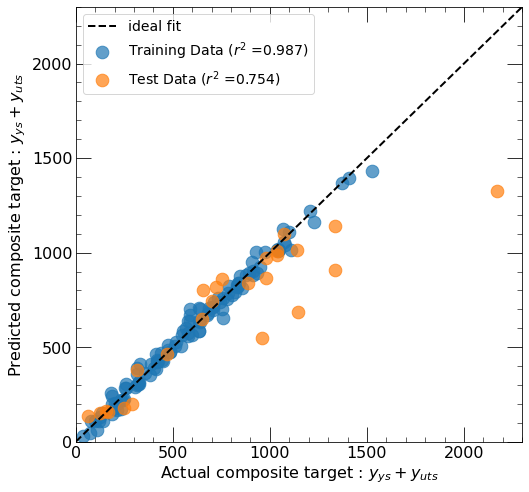

In [55]:
############## EVALUATION ##########################################################

print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,'gbr_GS'))
print('****************************************************************************')
feature_imp_df = pd.concat([pd.Series(X_train_unscaled_avg.columns),
                            pd.Series(gbr_gs_best.feature_importances_)], 
                           axis = 1)
feature_imp_df.columns=['feature_name','importance'];
print(feature_imp_df.sort_values('importance',ascending=False)[0:10])
feature_imp_df.index = feature_imp_df.feature_name

#feature_imp_df.sort_values('importance', ascending=False)[0:12].plot(kind="bar", figsize=(16,4))

plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train,r2_test)

### Estimating mean and standard deviation using the helper function bootstrap_estimator

In [33]:
## Using the hyperparmeters of the best estimator of GBR model 
from sklearn.ensemble import GradientBoostingRegressor
# parameters = dict(criterion='mse', max_features='auto',
#                           min_samples_leaf=6, min_samples_split=5,
#                           n_estimators=50, random_state=20
    
#                  )


# parameters = dict(criterion='mse', max_features='sqrt',
#                           min_samples_leaf=6, min_samples_split=5,
#                           n_estimators=200, random_state=20)

# gbr = GradientBoostingRegressor(**parameters)


mean , std  = bootstrap_estimator(gbr_gs_best, X_train, y_train, X_test, n_iter=1000)


print(pd.DataFrame([mean,std]))

mean_train , std_train  = bootstrap_estimator(gbr_gs_best, X_train, y_train, X_train, n_iter=1000)


           0           1           2           3           4            5   \
0  929.137019  425.779825  216.480907  187.353125  174.189987  1030.710719   
1   55.017810   52.808141   54.286242   54.995135   54.843360    46.840658   

           6           7           8           9   ...          15  \
0  809.038394  753.242625  481.969128  241.912429  ...  561.793125   
1   45.225860   44.602465   35.023962   40.225164  ...   55.622879   

            16           17          18          19          20          21  \
0  1125.774227  1012.203365  975.984252  949.148238  930.218597  855.209507   
1    85.180192    80.178746   81.345491   84.043453   90.696313   89.334358   

           22          23          24  
0  810.973552  707.143013  584.727649  
1   83.285823   88.425426   71.946189  

[2 rows x 25 columns]


### plotting the uncertainties for the test data 

r2 score test data: 0.7256247865135107
r2 score train data: 0.9800219007060865


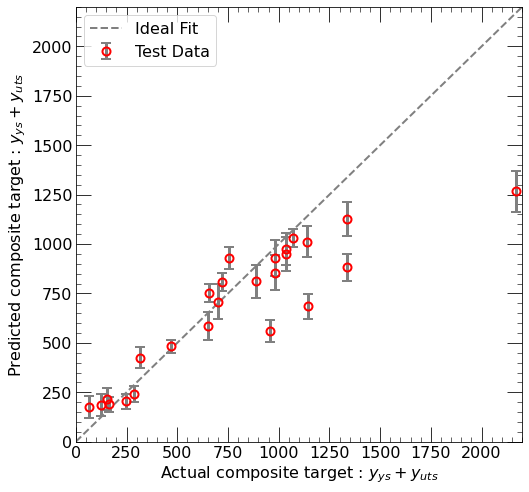

In [34]:
plt.figure(figsize=(8,8))

plt.errorbar(y_test,mean,yerr=std,ecolor = 'grey',mfc='None', mec='red',mew=2,elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Test Data')

plt.xlabel('Actual composite target : $y_{ys} + y_{uts}$',fontsize=16)
plt.ylabel('Predicted composite target : $y_{ys} + y_{uts}$',fontsize=16)
plt.axline((0, 0), (1200, 1200), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)
plt.xlim(0,2200)
plt.ylim(0,2200)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')

print('r2 score test data:',r2_score(y_test,mean))
print('r2 score train data:',r2_score(y_train,mean_train))   
# mean_squared_error(y_test,mean,squared=False)
# mean_absolute_error(y_test,mean)

### Plotting the uncertainties for the train data 

r2 score test data: 0.7256247865135107
r2 score train data: 0.9800219007060865


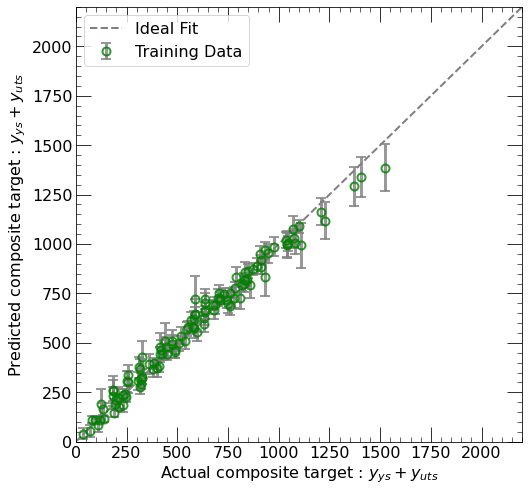

In [35]:
plt.figure(figsize=(8,8))

plt.errorbar(y_train,mean_train,yerr=std_train,mfc='None',mec='green',mew=2,ecolor = 'grey',alpha=0.8, elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Training Data')
plt.xlabel('Actual composite target : $y_{ys} + y_{uts}$',fontsize=16)
plt.ylabel('Predicted composite target : $y_{ys} + y_{uts}$',fontsize=16)
plt.axline((0, 0), (1000, 1000), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


plt.xlim(0,2200)
plt.ylim(0,2200)
print('r2 score test data:',r2_score(y_test,mean))
print('r2 score train data:',r2_score(y_train,mean_train))  

# mean_squared_error(y_test,mean,squared=False)
# mean_absolute_error(y_test,mean)

### Reading .csv file of composition (candidate search space)  and converting weight percent to atom percent

In [36]:
from convesrion_weightpct_atpct import wtpct_To_atpct
df_test_composition = pd.read_csv('data/compositions_test_24degc_allcombinations.csv')
df_test_composition['formula']=[wtpct_To_atpct(i) for i in df_test_composition.wt_pct]
df_test_total = df_test_composition[['formula','T','target']]
#df_test_total['T']=1300
df_test_total.head()



,formula,T,target
0,Nb80.9B7.2C6.4N5.5,24,0
1,Nb76.4B6.8C6.2N10.6,24,0
2,Nb72.4B6.5C5.9N15.2,24,0
3,Nb68.7B6.3C5.7N19.4,24,0
4,Nb65.3B6.0C5.4N23.3,24,0


In [37]:
print(len(df_test_total))
df_test_final = df_test_total
df_test_final.tail()

1666625


,formula,T,target
1666620,Nb60.8Ta14.2W14.0Re11.0,24,0
1666621,Nb59.8Ta14.3W14.1Re11.8,24,0
1666622,Nb58.9Ta14.4W14.2Re12.6,24,0
1666623,Nb57.9Ta14.5W14.3Re13.4,24,0
1666624,Nb56.9Ta14.6W14.4Re14.2,24,0


### Generate Features for the search space using CBFV

In [38]:
X_test_comp, y_test_comp, formulae_test_comp, skipped_train = generate_features(df_test_final,elem_prop='f3_revised',drop_duplicates=False,extend_features=True)
#X_test_comp[110000:160004]

Processing Input Data: 100%|███████| 1666625/1666625 [02:16<00:00, 12194.82it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████| 1666625/1666625 [02:00<00:00, 13877.46it/s]


	Creating Pandas Objects...


### Using only weighted average values 

In [39]:
X_test_comp_avg  = X_test_comp[['avg_Atomic_Radius','avg_Pauling_Electronegativity','avg_number_of_valence_electrons','avg_Cohesive_energy_ev_atom',
            'avg_Bulk_modulus_RT_Gpa','avg_Elastic_modulus_RT_Gpa','avg_Shear_modulus_RT_Gpa','avg_Melting_point_(K)','avg_rate_shear_mod_Mpa_perK',
            'avg_Solid_Solubility_atpct','avg_lattice_constant_A','avg_BEC_percm3','avg_Av.Valence_bond_strength_ev','avg_EngelZ_e/a','T']]



In [40]:
## to test if there is any null value 
pd.DataFrame(X_test_comp_avg).isnull().sum()

avg_Atomic_Radius                  0
avg_Pauling_Electronegativity      0
avg_number_of_valence_electrons    0
avg_Cohesive_energy_ev_atom        0
avg_Bulk_modulus_RT_Gpa            0
avg_Elastic_modulus_RT_Gpa         0
avg_Shear_modulus_RT_Gpa           0
avg_Melting_point_(K)              0
avg_rate_shear_mod_Mpa_perK        0
avg_Solid_Solubility_atpct         0
avg_lattice_constant_A             0
avg_BEC_percm3                     0
avg_Av.Valence_bond_strength_ev    0
avg_EngelZ_e/a                     0
T                                  0
dtype: int64

### Normalization and Prediction
### for predicting mean and std deviation of candidate space we have used entire dataset for training keeping the hyperparameters same for the model 

In [41]:
X_train_all = np.concatenate((X_train_unscaled_avg,X_test_unscaled_avg),axis = 0)
y_train_all = np.concatenate((y_train,y_test),axis=0)

scaler = StandardScaler()
X_train_all_scaled = scaler.fit_transform(X_train_all) ## fit and transform training data and 

X_test_comp_avg_scaled  = scaler.transform(X_test_comp_avg) # transform test data
print('maximum value of the UTS in the experimental data:',y_train_all.max())


maximum value of the UTS in the experimental data: 2168.48


In [42]:
# Estimating mean and standard deviation for all the available experimental data
mean_train_all , std_train_all  = bootstrap_estimator(gbr_gs_best, X_train_all_scaled, y_train_all, X_train_all_scaled, n_iter=1000)


r2 score train data: 0.9794820220167153


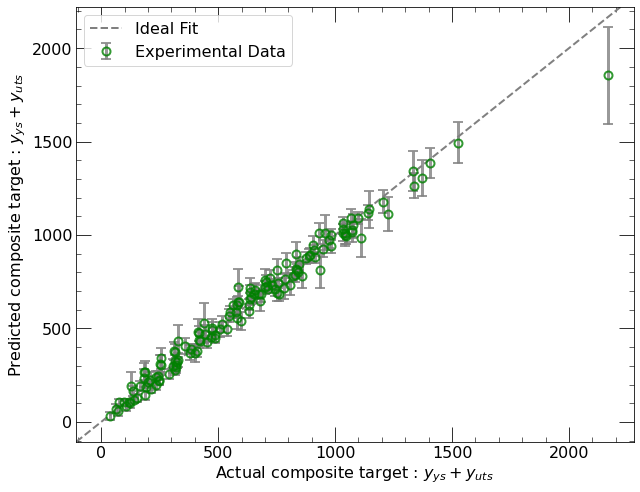

In [43]:
plt.figure(figsize=(10,8))
plt.errorbar(y_train_all,mean_train_all,yerr=std_train_all,mfc='None',mec='green',mew=2,ecolor = 'grey',alpha=0.8, elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Experimental Data')
#plt.errorbar(y_train,mean_train,yerr=std_train,ecolor = 'grey', elinewidth= 3,c ='red',ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='UTS (MPa) train')

plt.xlabel('Actual composite target : $y_{ys} + y_{uts}$',fontsize=16)
plt.ylabel('Predicted composite target : $y_{ys} + y_{uts}$',fontsize=16)
plt.axline((0, 0), (1200, 1200), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


print('r2 score train data:',r2_score(y_train_all,mean_train_all))   
# mean_squared_error(y_test,mean,squared=False)
# mean_absolute_error(y_test,mean)

### Calculating EI

In [44]:
ei,predicted_property,std = Expected_Improvement(X_test_comp_avg_scaled, X_train_all_scaled, y_train_all,gbr_gs_best,xi=0.01)


### Saving the Predicted value and EI in .csv file


In [45]:
df_predict = pd.DataFrame({"ei":ei, "predicted_property":predicted_property, "std":std})
df_predict_final = df_test_final.join(df_predict)
df_predict_final['wt_pct'] = df_test_composition['wt_pct']

df_predict_final_sorted = df_predict_final.sort_values('ei',ascending=False)
#df_predict_final_sorted.to_csv('data/model_output/paper_add_quarterany.csv')
df_predict_final_sorted[0:10]


,formula,T,target,ei,predicted_property,std,wt_pct
1546644,Nb87.0Zr1.1Hf0.6W11.3,24,0,14.535234,1854.529148,260.895738,Nb78Zr1Hf1W20
1562644,Nb87.0Zr1.1Ta0.6W11.3,24,0,14.242862,1856.200576,258.391665,Nb78Zr1Ta1W20
1635044,Nb86.8Hf1.2Ta0.6W11.4,24,0,13.388001,1850.424073,257.254046,Nb77Hf2Ta1W20
1634644,Nb87.5Hf0.6Ta0.6W11.3,24,0,13.037456,1849.959776,255.625387,Nb78Hf1Ta1W20
1562684,Nb85.7Zr1.1Ta1.7W11.4,24,0,12.850515,1844.129093,257.969527,Nb76Zr1Ta3W20
1562683,Nb86.4Zr1.1Ta1.7W10.8,24,0,12.730415,1839.964558,259.698713,Nb77Zr1Ta3W19
1635444,Nb86.2Hf1.8Ta0.6W11.5,24,0,12.676970,1844.906405,256.560603,Nb76Hf3Ta1W20
1635464,Nb85.5Hf1.8Ta1.2W11.5,24,0,12.676970,1844.906405,256.560603,Nb75Hf3Ta2W20
1635064,Nb86.2Hf1.2Ta1.2W11.5,24,0,12.669801,1845.013035,256.459444,Nb76Hf2Ta2W20
1562664,Nb86.4Zr1.1Ta1.2W11.3,24,0,12.588779,1845.709894,255.608312,Nb77Zr1Ta2W20
